In [2]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt

In [3]:
# Load first 500 rows from csv
df1 = pd.read_csv('../TH_Data/500_rows.csv', index_col=0)

# Load second 500 rows from csv
df2 = pd.read_csv('../TH_Data/500_2_rows.csv', index_col=0)

# Concatenate dfs
frames = [df1, df2]
df = pd.concat(frames, ignore_index=True)

# normalizing avg_ratings with MinMax and Mean
df['minmax_norm_ratings'] = 1 + (df['avg_rating'] - df['avg_rating'].min()) / (df['avg_rating'].max() - df['avg_rating'].min()) * 9
df['mean_norm_ratings'] = (1 + (df['avg_rating'] - df['avg_rating'].mean()) / (df['avg_rating'].max() - df['avg_rating'].min())) * 4.5 +1
# df['minmax_norm'] = 1 + (df['avg_rating'] - df['avg_rating'].min()) / (df['avg_rating'].max() - df['avg_rating'].min()) * 9
# df['mean_norm'] = 1 + (df['avg_rating'] - df['avg_rating'].mean()) / (df['avg_rating'].max() - df['avg_rating'].min()) * 4.5

display(df.head())

,url,title,authorname,avg_rating,num_rat,num_rev,total_pages,ori_year,places,series,awards,genre3,minmax_norm_ratings,mean_norm_ratings
0,https://www.goodreads.com//book/show/13496.A_G...,A Game of Thrones,George R.R. Martin,4.44,"2,084,416","55,502",835.0,2005.0,The Lands of Ice and Fire,1,"Nebula Award Nominee for Best Novel (1997), Lo...","['Fantasy', 'Fiction', 'Fantasy']",7.230769,6.320508
1,https://www.goodreads.com//book/show/30.J_R_R_...,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,J.R.R. Tolkien,4.60,"114,607","1,837",1728.0,2012.0,Middle-earth,1,NaN,"['Fantasy', 'Fiction', 'Classics']",8.021978,6.716113
2,https://www.goodreads.com//book/show/186074.Th...,The Name of the Wind,Patrick Rothfuss,4.52,"759,974","43,986",662.0,2007.0,NaN,1,Locus Award Nominee for Best First Novel and B...,"['Fantasy', 'Fiction', 'Fantasy']",7.626374,6.518310
3,https://www.goodreads.com//book/show/7235533-t...,The Way of Kings,Brandon Sanderson,4.61,"334,282","22,153",1007.0,2010.0,Roshar,1,Locus Award Nominee for Best Fantasy Novel (20...,"['Fantasy', 'Fiction', 'Fantasy']",8.071429,6.740838
4,https://www.goodreads.com//book/show/11127.The...,The Chronicles of Narnia,C.S. Lewis,4.26,"545,434","10,668",767.0,2002.0,"London, England (United Kingdom)",1,NaN,"['Fantasy', 'Classics', 'Fiction']",6.340659,5.875453


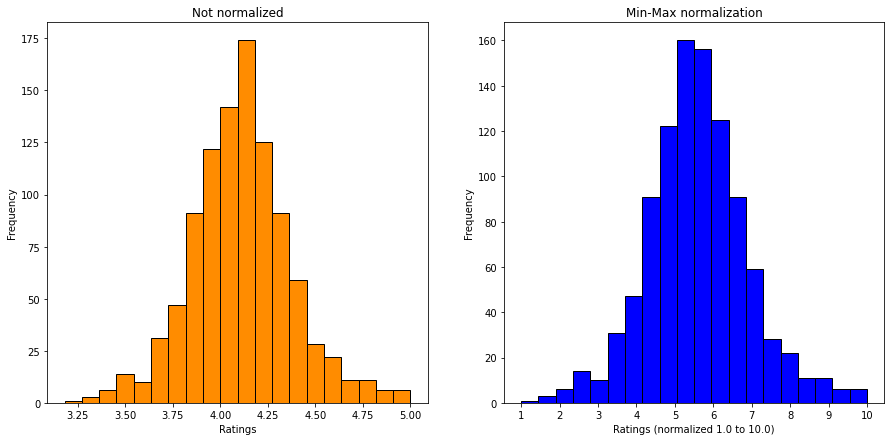

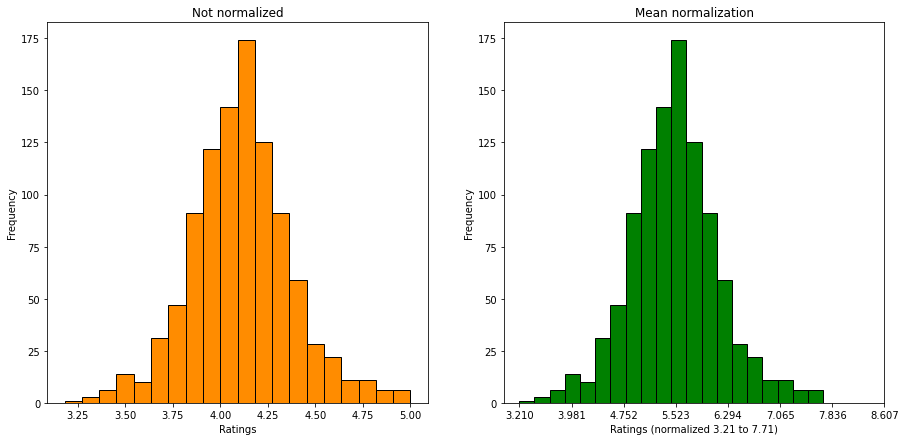

In [9]:
# Plots the histogram of the normalized version of a column compared with the not normalized one

def plot_norm(not_norm_series, norm_series, norm_type: str, bins_ = 20, not_norm_color='darkorange', norm_color='blue', edgecolor_='black'):
    
    # defining some useful variables
    norm_min = round(norm_series.min(), 2)
    norm_max = round(norm_series.max(), 2)

    
    # Set the number of subplots and the fig dimensions
    fig, ax = plt.subplots(1, 2, figsize = (15,7))

    # defining the not-normilized graph
    ax[0].hist(not_norm_series, bins=bins_, color=not_norm_color, histtype='bar', edgecolor=edgecolor_)
    ax[0].set_title("Not normalized")
    ax[0].set_xlabel('Ratings')
    ax[0].set_ylabel('Frequency')

    # defining the normilized graph
    ax[1].hist(norm_series, bins=bins_, color=norm_color, histtype='bar', edgecolor=edgecolor_)
    ax[1].set_title(norm_type)
    ax[1].set_xlabel(f'Ratings (normalized {norm_min} to {norm_max})')
    ax[1].set_ylabel('Frequency')

    # Set the ticks for x axis in normalized graph, according to the data range
    plt.sca(ax[1])
    plt.xticks(np.arange(norm_min, norm_max + 1, norm_max / 10))

    plt.savefig(format='png', fname=f'./{norm_type}.png')

# Examples
plot_norm(df.avg_rating, df.minmax_norm_ratings, norm_type='Min-Max normalization')
plot_norm(df.avg_rating, df.mean_norm_ratings, norm_type='Mean normalization', norm_color='green')




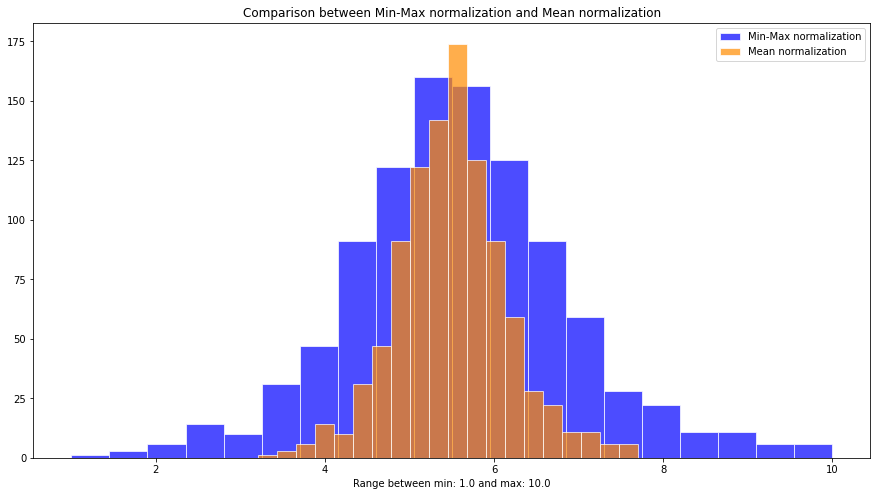

In [10]:
def plot_compared_norms(first_norm, second_norm, first_norm_type: str, second_norm_type: str, \
    bins_ = 20, first_norm_color='blue',second_norm_color='darkorange', edgecolor_='white'):
    min_range = round(np.array([first_norm.min(), second_norm.min()]).min(), 2)
    max_range = round(np.array([first_norm.max(), second_norm.max()]).max(), 2)


    # Set the fig dimensions
    fig, graph = plt.subplots(figsize = (15, 8))
    
    # defining the normilized graph
    graph.hist(first_norm, bins = bins_, alpha = 0.7, color=first_norm_color, edgecolor = edgecolor_, label = first_norm_type)
    graph.hist(second_norm, bins = bins_, alpha = 0.7, color=second_norm_color, edgecolor = edgecolor_, label = second_norm_type)
    graph.set_title(f'Comparison between {first_norm_type} and {second_norm_type}')
    graph.legend()
    
    # Set the range of the ticks in x axis, according to data range
    graph.set_xlabel(f'Range between min: {min_range} and max: {max_range}')

    plt.savefig(format='png', fname='./compared_norm.png')

# Example
plot_compared_norms(df.minmax_norm_ratings, df.mean_norm_ratings, first_norm_type = 'Min-Max normalization', second_norm_type='Mean normalization')

In [11]:
# Create models from data
def best_fit_distribution(data, bins=20, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]


    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Plots the best fit distribution given a pandas series, the title and the labels
def plot_best_fit_distribution(data: pd.Series, title: str, xlabel: str, ylabel: str, save_plot = False):

    matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
    matplotlib.style.use('ggplot')

    # Plot for comparison
    plt.figure(figsize=(12,8))
    # ax = df.minmax_norm.plot(kind='hist', bins=20, normed=True, alpha=0.5, color=plt.rcParams['axes.color_cycle'][1])
    # ax = df.minmax_norm.plot(kind='hist', bins=20, alpha=0.5, color='blue', edgecolor = 'white')
    ax = data.hist(bins=20, alpha=0.5, density=True, color='blue', edgecolor = 'white')
    # Save plot limits
    dataYLim = ax.get_ylim()
    

    # Find best fit distribution
    best_fit_name, best_fit_params = best_fit_distribution(data, 20, ax)
    best_dist = getattr(st, best_fit_name)

    # Update plots
    ax.set_ylim(dataYLim)
    ax.set_title(f'{title} \n All Fitted Distributions')
    ax.set_xlabel(u'Normalized ratings 1 - 10')
    ax.set_ylabel('Frequency')

    # saving the fitting comparison to png file if needed
    if save_plot:
        plt.savefig(format='png', fname=f'./{title}distribution_comparison.png')

    # Make PDF with best params 
    pdf = make_pdf(best_dist, best_fit_params)

    # Display
    plt.figure(figsize=(12,8))
    ax = pdf.plot(lw=2, label='PDF', legend=True)
    data.plot(kind='hist', bins=20, alpha=0.5, density=True, label='Data', legend=True, ax=ax)

    param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
    param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
    dist_str = '{}({})'.format(best_fit_name, param_str)

    ax.set_title(f'{title} with best fit distribution \n {dist_str}')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    # saving the fitting comparison to png file if needed
    if save_plot:
        plt.savefig(format='png', fname=f'./{title}best_fit.png')

plot_best_fit_distribution(df.mean_norm_ratings, title='Min-Max Average Ratings Normalization', xlabel='Normalized ratings', ylabel='Frequency')

KeyboardInterrupt: 